In [1]:
# import requirements
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# import requirements
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

import copy


# choose problem formulation number
# between 0-5
dike_model, planning_steps = get_model_for_problem_formulation(3)

# specify uncertainties
uncertainties = copy.deepcopy(dike_model.uncertainties)

# specify levers
levers = copy.deepcopy(dike_model.levers)

C:\Users\Adli\PycharmProjects\epa141A-model\MBDM\Lib\site-packages\ema_workbench\em_framework\evaluators.py:58: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [2]:
# check lever
for l in dike_model.levers:
    print(f"{l.name} ({l.__class__.__name__}): {getattr(l, 'categories', getattr(l, 'lower_bound', ''))} to {getattr(l, 'upper_bound', '')}")


0_RfR 0 (IntegerParameter): 0 to 1
1_RfR 0 (IntegerParameter): 0 to 1
2_RfR 0 (IntegerParameter): 0 to 1
3_RfR 0 (IntegerParameter): 0 to 1
4_RfR 0 (IntegerParameter): 0 to 1
EWS_DaysToThreat (IntegerParameter): 0 to 4
A.1_DikeIncrease 0 (IntegerParameter): 0 to 10
A.2_DikeIncrease 0 (IntegerParameter): 0 to 10
A.3_DikeIncrease 0 (IntegerParameter): 0 to 10
A.4_DikeIncrease 0 (IntegerParameter): 0 to 10
A.5_DikeIncrease 0 (IntegerParameter): 0 to 10


In [3]:
# defining specific policies

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

# policies from '../saved_runs/scenarios_for_robustness/deventer_no_dikes.csv' file
policies = [
    Policy(
        "Policy 1 - Without RfR",
        **dict(
            get_do_nothing_dict(),
            **{'0_RfR 0':0,
                '1_RfR 0':0,
                '2_RfR 0':0,
                '3_RfR 0':0,
                '4_RfR 0':0,
                '0_RfR 1':0,
                'EWS_DaysToThreat 0':1,
                'A.1_DikeIncrease 0':0,
                'A.2_DikeIncrease 0':0,
                'A.3_DikeIncrease 0':4,
                'A.4_DikeIncrease 0':3,
                'A.5_DikeIncrease 0':8}
        )
    ),
    Policy(
        "policy 2 - Deventer Dike and RfR 2",
        **dict(
            get_do_nothing_dict(),
            **{'0_RfR 0':0,
                '1_RfR 0':0,
                '2_RfR 0':1,
                '3_RfR 0':0,
                '4_RfR 0':0,
                '0_RfR 1':0,
                'EWS_DaysToThreat 0':0,
                'A.1_DikeIncrease 0':0,
                'A.2_DikeIncrease 0':0,
                'A.3_DikeIncrease 0':0,
                'A.4_DikeIncrease 0':3,
                'A.5_DikeIncrease 0':9}
        )
    ),
    Policy(
        "policy 3 - Deventer Dike and RfR 2,3",
        **dict(
            get_do_nothing_dict(),
            **{'0_RfR 0':0,
                '1_RfR 0':0,
                '2_RfR 0':1,
                '3_RfR 0':1,
                '4_RfR 0':0,
                '0_RfR 1':0,
                'EWS_DaysToThreat 0':1,
                'A.1_DikeIncrease 0':0,
                'A.2_DikeIncrease 0':0,
                'A.3_DikeIncrease 0':2,
                'A.4_DikeIncrease 0':3,
                'A.5_DikeIncrease 0':8}
        )
    ),

    Policy(
        "policy 4 - Deventer Dike and RfR 3",
        **dict(
            get_do_nothing_dict(),
            **{'0_RfR 0':0,
                '1_RfR 0':0,
                '2_RfR 0':0,
                '3_RfR 0':1,
                '4_RfR 0':0,
                '0_RfR 1':0,
                'EWS_DaysToThreat 0':1,
                'A.1_DikeIncrease 0':0,
                'A.2_DikeIncrease 0':0,
                'A.3_DikeIncrease 0':3,
                'A.4_DikeIncrease 0':4,
                'A.5_DikeIncrease 0':7}
        )
    ),

    Policy(
        "policy 5 - Zutphen Dike and No RfR",
        **dict(
            get_do_nothing_dict(),
            **{'0_RfR 0':0,
                '1_RfR 0':0,
                '2_RfR 0':0,
                '3_RfR 0':0,
                '4_RfR 0':0,
                '0_RfR 1':0,
                'EWS_DaysToThreat 0':0,
                'A.1_DikeIncrease 0':1,
                'A.2_DikeIncrease 0':3,
                'A.3_DikeIncrease 0':8,
                'A.4_DikeIncrease 0':7,
                'A.5_DikeIncrease 0':6}
        )
    ),

    Policy(
        "policy 7 - Zutphen Dike and RfR 2",
        **dict(
            get_do_nothing_dict(),
            **{'0_RfR 0':0,
                '1_RfR 0':0,
                '2_RfR 0':1,
                '3_RfR 0':0,
                '4_RfR 0':0,
                '0_RfR 1':0,
                'EWS_DaysToThreat 0':1,
                'A.1_DikeIncrease 0':0,
                'A.2_DikeIncrease 0':0,
                'A.3_DikeIncrease 0':8,
                'A.4_DikeIncrease 0':6,
                'A.5_DikeIncrease 0':6}
        )
    )

]

In [4]:
# running the model through EMA workbench
# need to be run twice if NaN exist
n_scenarios = 75   # using 2500 uncertainty scenarios
with MultiprocessingEvaluator(dike_model, n_processes=1) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

C:\Users\Adli\PycharmProjects\epa141A-model\MBDM\Lib\site-packages\ema_workbench\em_framework\evaluators.py:349: UserWarning: the number of processes cannot be more then 16
  warnings.warn(
100%|████████████████████████████████████████| 450/450 [01:08<00:00,  6.58it/s]


In [5]:
# observing the simulation runs
experiments, outcomes = results
print(outcomes.keys())
experiments

dict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,A.4_DikeIncrease 0,A.5_DikeIncrease 0,scenario,policy,model,0_RfR 1,EWS_DaysToThreat 0
0,122.0,118.881144,1.5,0.945744,254.295003,10,0.909039,338.797265,1.0,0.914335,...,0.0,0.0,4.0,3.0,8.0,0,Policy 1 - Without RfR,dikesnet,0.0,1.0
1,85.0,173.252298,10,0.626397,251.825459,1.5,0.379822,120.380925,10,0.365722,...,0.0,0.0,4.0,3.0,8.0,1,Policy 1 - Without RfR,dikesnet,0.0,1.0
2,77.0,280.985697,1.5,0.467647,232.671188,10,0.205515,101.352578,10,0.286695,...,0.0,0.0,4.0,3.0,8.0,2,Policy 1 - Without RfR,dikesnet,0.0,1.0
3,41.0,41.870772,1.0,0.458500,337.418322,1.0,0.679606,177.337648,1.0,0.555145,...,0.0,0.0,4.0,3.0,8.0,3,Policy 1 - Without RfR,dikesnet,0.0,1.0
4,80.0,225.614691,1.0,0.302350,275.953316,10,0.359820,182.566330,10,0.543551,...,0.0,0.0,4.0,3.0,8.0,4,Policy 1 - Without RfR,dikesnet,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,108.0,114.741135,10,0.909012,174.085016,1.0,0.113941,86.068636,1.5,0.905514,...,0.0,0.0,8.0,6.0,6.0,70,policy 7 - Zutphen Dike and RfR 2,dikesnet,0.0,1.0
446,131.0,220.331437,10,0.604067,121.370443,10,0.070335,331.037681,1.5,0.592709,...,0.0,0.0,8.0,6.0,6.0,71,policy 7 - Zutphen Dike and RfR 2,dikesnet,0.0,1.0
447,117.0,290.793585,1.5,0.542504,39.728728,1.0,0.415602,279.681315,1.5,0.662486,...,0.0,0.0,8.0,6.0,6.0,72,policy 7 - Zutphen Dike and RfR 2,dikesnet,0.0,1.0
448,38.0,73.998050,10,0.211187,208.754574,1.5,0.583951,130.502047,1.5,0.973149,...,0.0,0.0,8.0,6.0,6.0,73,policy 7 - Zutphen Dike and RfR 2,dikesnet,0.0,1.0


In [6]:
import pandas as pd
import numpy as np

criteria = list(outcomes.keys())
n_total = len(experiments)
n_policies = experiments['policy'].nunique()
n_scenarios = n_total // n_policies

flat_data = []
for i in range(n_total):
    row = {crit: outcomes[crit][i] for crit in criteria}
    row['Policy'] = experiments['policy'][i]
    row['Scenario'] = i % n_scenarios  # fixed: group every n_policies together
    flat_data.append(row)

df = pd.DataFrame(flat_data)
df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Policy,Scenario
0,0.000000e+00,0.000000,0.000000e+00,0.000000,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,0
1,4.028967e+06,0.002245,4.290705e+07,0.031173,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,1
2,5.997916e+07,0.058197,6.876969e+07,0.086275,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,2
3,2.898898e+08,0.097949,3.590581e+06,0.001673,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,3
4,2.047586e+09,0.657834,0.000000e+00,0.000000,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.000000e+00,0.000000,1.307258e+08,0.123898,3.728504e+07,0.0,1.258646e+07,0.0,4.027367e+07,0.0,30700000.0,0.0,policy 7 - Zutphen Dike and RfR 2,70
446,1.703651e+07,0.013224,2.695433e+08,0.248248,3.728504e+07,0.0,1.258646e+07,0.0,4.027367e+07,0.0,30700000.0,0.0,policy 7 - Zutphen Dike and RfR 2,71
447,4.266536e+07,0.032745,1.921873e+07,0.019361,3.728504e+07,0.0,1.258646e+07,0.0,4.027367e+07,0.0,30700000.0,0.0,policy 7 - Zutphen Dike and RfR 2,72
448,9.227438e+08,0.657011,0.000000e+00,0.000000,3.728504e+07,0.0,1.258646e+07,0.0,4.027367e+07,0.0,30700000.0,0.0,policy 7 - Zutphen Dike and RfR 2,73


In [7]:
# Step 2: Compute combined metrics for A4 and A5
# Step 2: Compute combined metrics for A4 and A5 (simplified)
df['Total Costs (in million)'] = (
    df['A.4 Total Costs'] + df['A.5 Total Costs']
) / 1000000

df['Expected Number of Deaths'] = (
    df['A.4_Expected Number of Deaths'] + df['A.5_Expected Number of Deaths']
)


# Step 3: Compute regret per scenario per criterion
regret_records = []

for scenario in df['Scenario'].unique():
    scen_df = df[df['Scenario'] == scenario]

    for criterion in ['Total Costs (in million)', 'Expected Number of Deaths']:
        best_value = scen_df[criterion].min()

        for _, row in scen_df.iterrows():
            regret_records.append({
                'Scenario': scenario,
                'Policy': row['Policy'],
                'Criterion': criterion,
                'Regret': row[criterion] - best_value
            })

regret_df = pd.DataFrame(regret_records)

# Step 4: Compute maximum regret per policy per criterion
max_regret = regret_df.groupby(['Policy', 'Criterion'])['Regret'].max().unstack()

# Optional: Display results
print("✅ Max regret per policy (A4 + A5 combined):")
print(max_regret)


✅ Max regret per policy (A4 + A5 combined):
Criterion                             Expected Number of Deaths  \
Policy                                                            
Policy 1 - Without RfR                                 0.009768   
policy 2 - Deventer Dike and RfR 2                     0.011532   
policy 3 - Deventer Dike and RfR 2,3                   0.008379   
policy 4 - Deventer Dike and RfR 3                     0.001869   
policy 5 - Zutphen Dike and No RfR                     0.063193   
policy 7 - Zutphen Dike and RfR 2                      0.042844   

Criterion                             Total Costs (in million)  
Policy                                                          
Policy 1 - Without RfR                               26.565342  
policy 2 - Deventer Dike and RfR 2                   34.247072  
policy 3 - Deventer Dike and RfR 2,3                 23.228375  
policy 4 - Deventer Dike and RfR 3                    4.849030  
policy 5 - Zutphen Dike and N

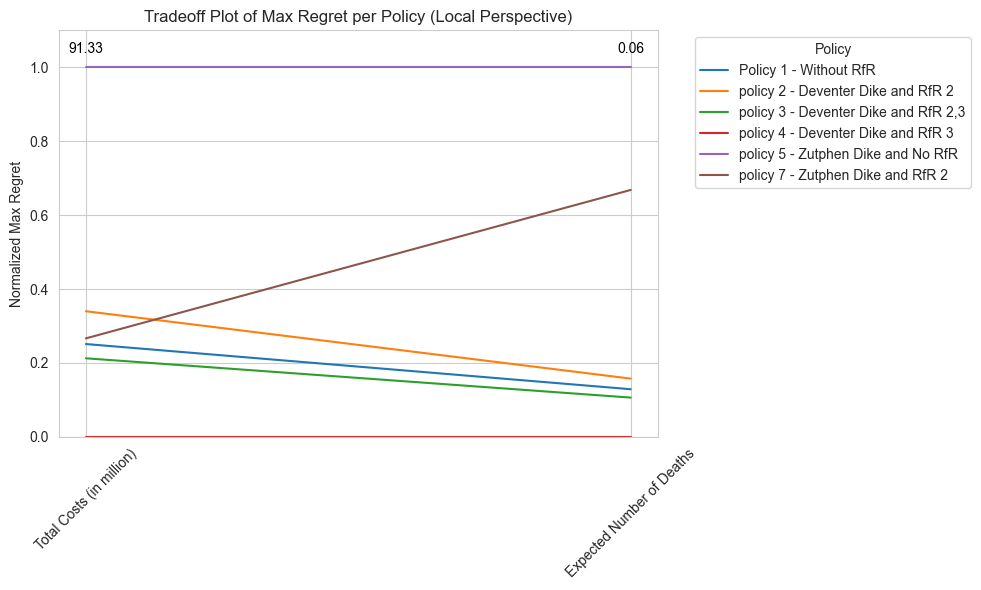

In [8]:
from sklearn.preprocessing import MinMaxScaler
# Define desired order of criteria
desired_order = [
    'Total Costs (in million)',
    'Expected Number of Deaths'
]

# Reorder max_regret
max_regret = max_regret[desired_order]

# Normalize it
normalized = pd.DataFrame(
    MinMaxScaler().fit_transform(max_regret),
    columns=max_regret.columns,
    index=max_regret.index
)

# Plot like the reference figure
plt.figure(figsize=(10, 6))
for policy_id in normalized.index:
    plt.plot(desired_order, normalized.loc[policy_id, desired_order], label=str(policy_id))

# Add max value labels (absolute regret values) on top of each axis
absolute_max = max_regret[desired_order].max()
for i, col in enumerate(desired_order):
    value = absolute_max[col]
    plt.text(i, 1.03, f"{value:,.2f}", ha='center', va='bottom',
             fontsize=10, color='black')

# adjust plot layout
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.ylabel("Normalized Max Regret")
plt.title("Tradeoff Plot of Max Regret per Policy (Local Perspective)")
plt.legend(title="Policy", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Policy,Scenario,Total Costs (in million),Expected Number of Deaths
0,0.000000e+00,0.000000,0.000000e+00,0.000000,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,0,56.917109,0.0
1,4.028967e+06,0.002245,4.290705e+07,0.031173,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,1,56.917109,0.0
2,5.997916e+07,0.058197,6.876969e+07,0.086275,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,2,56.917109,0.0
3,2.898898e+08,0.097949,3.590581e+06,0.001673,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,3,56.917109,0.0
4,2.047586e+09,0.657834,0.000000e+00,0.000000,2.640338e+07,0.0,8.453408e+06,0.0,4.846370e+07,0.0,0.0,0.0,Policy 1 - Without RfR,4,56.917109,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.000000e+00,0.000000,1.307258e+08,0.123898,3.728504e+07,0.0,1.258646e+07,0.0,4.027367e+07,0.0,30700000.0,0.0,policy 7 - Zutphen Dike and RfR 2,70,52.860130,0.0
446,1.703651e+07,0.013224,2.695433e+08,0.248248,3.728504e+07,0.0,1.258646e+07,0.0,4.027367e+07,0.0,30700000.0,0.0,policy 7 - Zutphen Dike and RfR 2,71,52.860130,0.0
447,4.266536e+07,0.032745,1.921873e+07,0.019361,3.728504e+07,0.0,1.258646e+07,0.0,4.027367e+07,0.0,30700000.0,0.0,policy 7 - Zutphen Dike and RfR 2,72,52.860130,0.0
448,9.227438e+08,0.657011,0.000000e+00,0.000000,3.728504e+07,0.0,1.258646e+07,0.0,4.027367e+07,0.0,30700000.0,0.0,policy 7 - Zutphen Dike and RfR 2,73,52.860130,0.0


In [10]:
# check pareto efficiency
import pandas as pd
import numpy as np

def is_pareto_efficient(df):
    """
    Identify Pareto-efficient rows in a DataFrame (minimize all columns).
    Returns a boolean mask where True indicates the row is Pareto-optimal.
    """
    data = df.to_numpy()
    is_efficient = np.ones(data.shape[0], dtype=bool)
    for i, row in enumerate(data):
        if is_efficient[i]:
            # Any row that is strictly better in all objectives will dominate
            is_efficient[is_efficient] = np.any(data[is_efficient] < row, axis=1) | np.all(data[is_efficient] == row, axis=1)
            is_efficient[i] = True  # Keep the current row after comparison
    return is_efficient

# Example: apply to your max_regret DataFrame
# (Make sure to exclude policy column if it's an index)
pareto_mask = is_pareto_efficient(max_regret)
pareto_front = max_regret[pareto_mask]

print("Pareto-optimal policies:\n", pareto_front)


Pareto-optimal policies:
 Criterion                           Total Costs (in million)  \
Policy                                                         
policy 4 - Deventer Dike and RfR 3                   4.84903   

Criterion                           Expected Number of Deaths  
Policy                                                         
policy 4 - Deventer Dike and RfR 3                   0.001869  


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 2: Add subgroup and national metrics
df['Overijssel Costs (M)'] = (df['A.4 Total Costs'] + df['A.5 Total Costs']) / 1_000_000
df['Gelderland Costs (M)'] = (df['A.1 Total Costs'] + df['A.2 Total Costs'] + df['A.3 Total Costs']) / 1_000_000
df['National Gov Costs (M)'] = (df['RfR Total Costs'] + df['Expected Evacuation Costs']) / 1_000_000

df['Overijssel Deaths'] = df['A.4_Expected Number of Deaths'] + df['A.5_Expected Number of Deaths']
df['Gelderland Deaths'] = df['A.1_Expected Number of Deaths'] + df['A.2_Expected Number of Deaths'] + df['A.3_Expected Number of Deaths']

df['National Total Costs (in million)'] = (
    df['Overijssel Costs (M)'] +
    df['Gelderland Costs (M)'] +
    df['National Gov Costs (M)']
)

df['National Expected Number of Deaths'] = (
    df['Overijssel Deaths'] + df['Gelderland Deaths']
)

# Step 3: Compute regret
criteria_to_compare = [
    'Overijssel Costs (M)', 'Overijssel Deaths',
    'Gelderland Costs (M)', 'Gelderland Deaths',
    'National Gov Costs (M)',
    'National Total Costs (in million)', 'National Expected Number of Deaths'
]

regret_records = []
for scenario in df['Scenario'].unique():
    scen_df = df[df['Scenario'] == scenario]
    for criterion in criteria_to_compare:
        best_value = scen_df[criterion].min()
        for _, row in scen_df.iterrows():
            regret_records.append({
                'Scenario': scenario,
                'Policy': row['Policy'],
                'Criterion': criterion,
                'Regret': row[criterion] - best_value
            })

regret_df = pd.DataFrame(regret_records)
max_regret = regret_df.groupby(['Policy', 'Criterion'])['Regret'].max().unstack()

# Step 4: Reorder and normalize
desired_order = criteria_to_compare
max_regret = max_regret[desired_order]
normalized = pd.DataFrame(
    MinMaxScaler().fit_transform(max_regret),
    columns=desired_order,
    index=max_regret.index
)

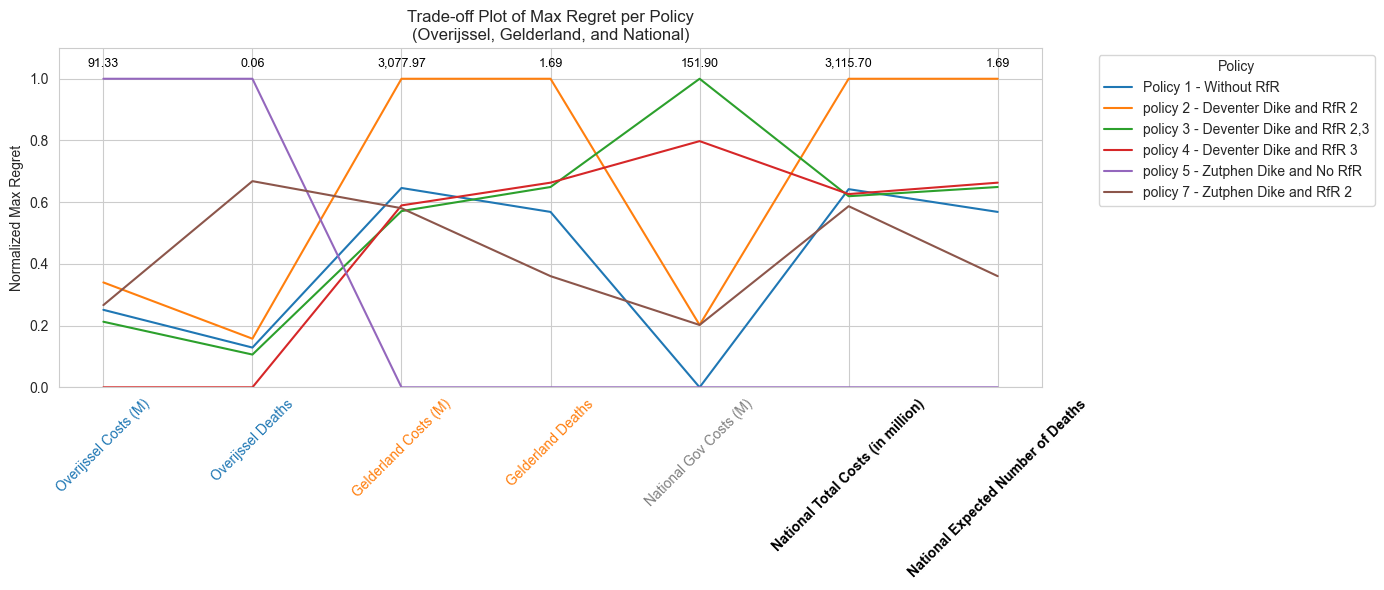

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Define ordered criteria and their attributes
desired_order = [
    'Overijssel Costs (M)',
    'Overijssel Deaths',
    'Gelderland Costs (M)',
    'Gelderland Deaths',
    'National Gov Costs (M)',
    'National Total Costs (in million)',
    'National Expected Number of Deaths'
]

# Region/color assignment for x-axis labels
label_styles = {
    'Overijssel Costs (M)': {'color': 'tab:blue', 'weight': 'normal'},
    'Overijssel Deaths': {'color': 'tab:blue', 'weight': 'normal'},
    'Gelderland Costs (M)': {'color': 'tab:orange', 'weight': 'normal'},
    'Gelderland Deaths': {'color': 'tab:orange', 'weight': 'normal'},
    'National Gov Costs (M)': {'color': 'gray', 'weight': 'normal'},
    'National Total Costs (in million)': {'color': 'black', 'weight': 'bold'},
    'National Expected Number of Deaths': {'color': 'black', 'weight': 'bold'}
}

# Reorder and normalize
max_regret = max_regret[desired_order]
normalized = pd.DataFrame(
    MinMaxScaler().fit_transform(max_regret),
    columns=desired_order,
    index=max_regret.index
)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
for policy_id in normalized.index:
    ax.plot(desired_order, normalized.loc[policy_id], label=str(policy_id))

# Annotate max regret values
absolute_max = max_regret.max()
for i, col in enumerate(desired_order):
    ax.text(i, 1.03, f"{absolute_max[col]:,.2f}", ha='center', va='bottom',
            fontsize=9, color='black')

# Custom tick coloring and bolding
ax.set_xticks(range(len(desired_order)))
ax.set_xticklabels(desired_order, rotation=45)
for tick_label, col in zip(ax.get_xticklabels(), desired_order):
    tick_label.set_color(label_styles[col]['color'])
    tick_label.set_fontweight(label_styles[col]['weight'])

# Styling
ax.set_ylim(0, 1.1)
ax.set_ylabel("Normalized Max Regret")
ax.set_title("Trade-off Plot of Max Regret per Policy\n(Overijssel, Gelderland, and National)")
ax.legend(title="Policy", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
plt.tight_layout()
plt.show()


In [13]:
def weighted_regret_index(cost_regret, death_regret, w_cost=0.4, w_death=0.6):
    return w_cost * cost_regret + w_death * death_regret

summary_df = pd.DataFrame(index=max_regret.index)

summary_df['Local Regret Index'] = [
    weighted_regret_index(
        max_regret.loc[p, 'Overijssel Costs (M)'],
        max_regret.loc[p, 'Overijssel Deaths']
    ) for p in summary_df.index
]

summary_df['National Regret Index'] = [
    weighted_regret_index(
        max_regret.loc[p, 'National Total Costs (in million)'],
        max_regret.loc[p, 'National Expected Number of Deaths']
    ) for p in summary_df.index
]

from sklearn.preprocessing import MinMaxScaler

normalized = pd.DataFrame(
    MinMaxScaler().fit_transform(summary_df),
    columns=[f"{col} (Norm)" for col in summary_df.columns],
    index=summary_df.index
)


In [14]:
print(normalized)

                                      Local Regret Index (Norm)  \
Policy                                                            
Policy 1 - Without RfR                                 0.250993   
policy 2 - Deventer Dike and RfR 2                     0.339759   
policy 3 - Deventer Dike and RfR 2,3                   0.212422   
policy 4 - Deventer Dike and RfR 3                     0.000000   
policy 5 - Zutphen Dike and No RfR                     1.000000   
policy 7 - Zutphen Dike and RfR 2                      0.266866   

                                      National Regret Index (Norm)  
Policy                                                              
Policy 1 - Without RfR                                    0.642134  
policy 2 - Deventer Dike and RfR 2                        1.000000  
policy 3 - Deventer Dike and RfR 2,3                      0.619335  
policy 4 - Deventer Dike and RfR 3                        0.626282  
policy 5 - Zutphen Dike and No RfR               

In [15]:
# Local Perspective (squared)
def weighted_regret_index(cost_regret, death_regret, w_cost=0.4, w_death=0.6):
    return w_cost * cost_regret + w_death * death_regret

summary_df = pd.DataFrame(index=max_regret.index)

summary_df['Local Regret Index'] = [
    (
        weighted_regret_index(
            max_regret.loc[p, 'Overijssel Costs (M)'],
            max_regret.loc[p, 'Overijssel Deaths']
        ) - weighted_regret_index(
            max_regret.loc[p, 'Gelderland Costs (M)'],
            max_regret.loc[p, 'Gelderland Deaths']
        )
    ) ** 2
    for p in summary_df.index
]

summary_df['National Regret Index'] = [
    weighted_regret_index(
        max_regret.loc[p, 'National Total Costs (in million)'],
        max_regret.loc[p, 'National Expected Number of Deaths']
    ) for p in summary_df.index
]

from sklearn.preprocessing import MinMaxScaler

normalized = pd.DataFrame(
    MinMaxScaler().fit_transform(summary_df),
    columns=[f"{col} (Norm)" for col in summary_df.columns],
    index=summary_df.index
)


In [16]:
print(normalized)

                                      Local Regret Index (Norm)  \
Policy                                                            
Policy 1 - Without RfR                                 0.435391   
policy 2 - Deventer Dike and RfR 2                     1.000000   
policy 3 - Deventer Dike and RfR 2,3                   0.346313   
policy 4 - Deventer Dike and RfR 3                     0.375128   
policy 5 - Zutphen Dike and No RfR                     0.000000   
policy 7 - Zutphen Dike and RfR 2                      0.355058   

                                      National Regret Index (Norm)  
Policy                                                              
Policy 1 - Without RfR                                    0.642134  
policy 2 - Deventer Dike and RfR 2                        1.000000  
policy 3 - Deventer Dike and RfR 2,3                      0.619335  
policy 4 - Deventer Dike and RfR 3                        0.626282  
policy 5 - Zutphen Dike and No RfR               

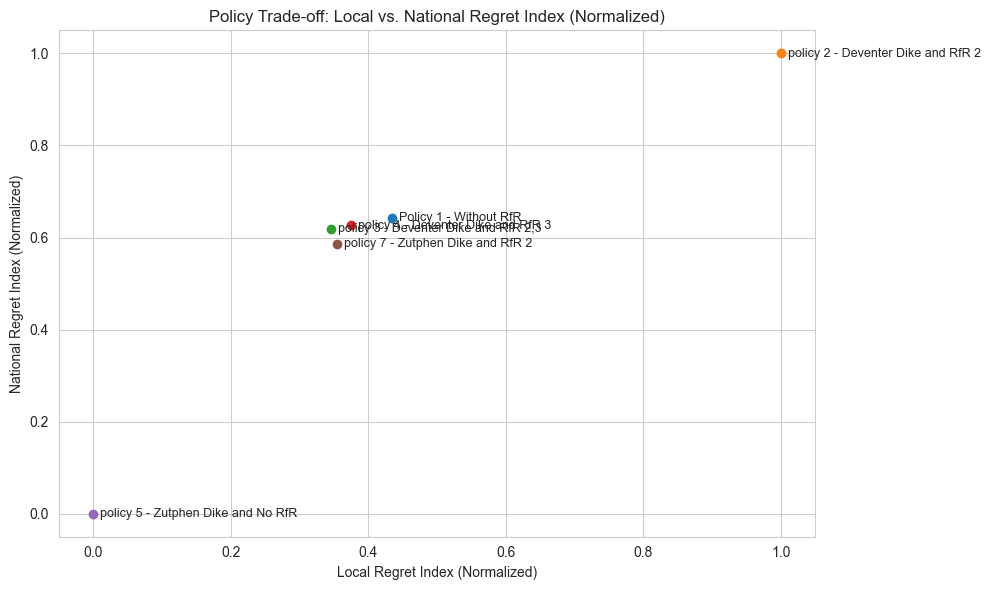

In [17]:
import matplotlib.pyplot as plt

# Scatter plot using existing normalized data
plt.figure(figsize=(10, 6))
for policy in normalized.index:
    x = normalized.loc[policy, 'Local Regret Index (Norm)']
    y = normalized.loc[policy, 'National Regret Index (Norm)']
    plt.scatter(x, y, label=policy)
    plt.text(x + 0.01, y, policy, fontsize=9, va='center')

plt.xlabel("Local Regret Index (Normalized)")
plt.ylabel("National Regret Index (Normalized)")
plt.title("Policy Trade-off: Local vs. National Regret Index (Normalized)")
plt.grid(True)
plt.tight_layout()
plt.show()
